[1] Loading data...

[2] Simple EDA...
Train shape: (256351, 69)
Test shape: (90067, 68)

Target distribution in train data (임신 성공 여부):
임신 성공 여부
0    0.741651
1    0.258349
Name: proportion, dtype: float64

Missing values in train (Top 5):
난자 해동 경과일                254915
PGS 시술 여부                254422
PGD 시술 여부                254172
착상 전 유전 검사 사용 여부         253633
임신 시도 또는 마지막 임신 경과 연수    246981
dtype: int64

Missing values in test (Top 5):
난자 해동 경과일                89575
PGS 시술 여부                89396
PGD 시술 여부                89286
착상 전 유전 검사 사용 여부         89134
임신 시도 또는 마지막 임신 경과 연수    86770
dtype: int64

[3] Data Preprocessing...

[4] Splitting data into train/validation...
X_train shape: (205080, 61)
X_val shape: (51271, 61)

[5] Training LightGBM model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 52982, number of negative: 152098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of tes

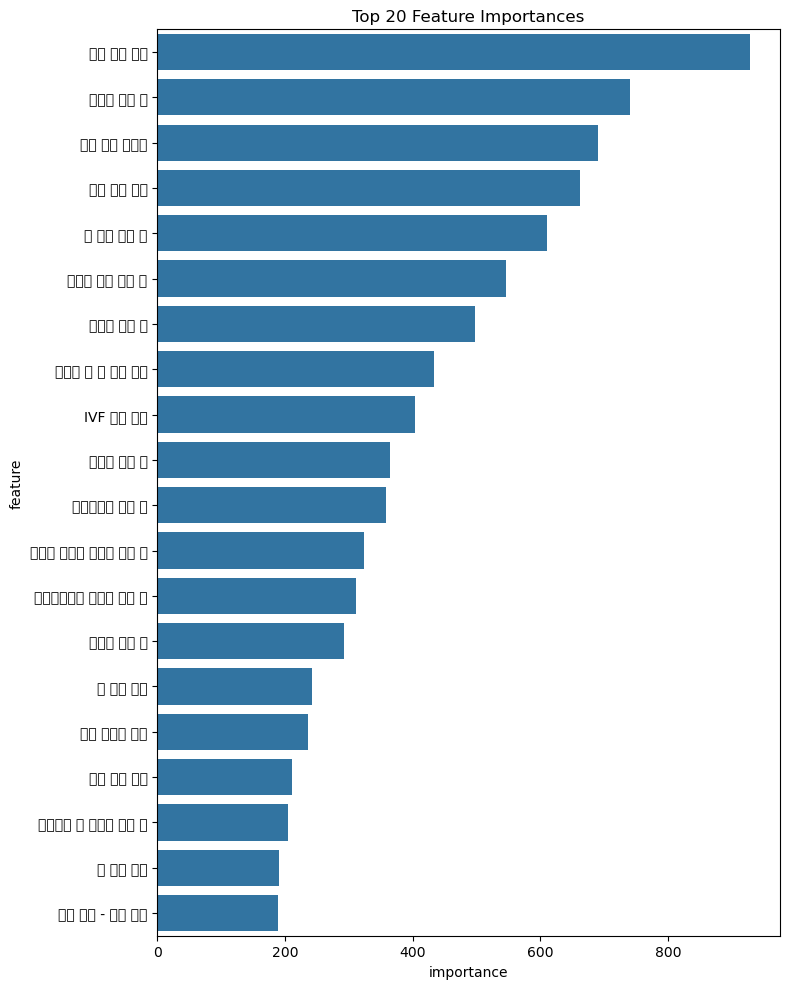

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

import warnings
warnings.filterwarnings('ignore')


def add_unknown_and_fit_encoder(series: pd.Series, le: LabelEncoder):
    """
    주어진 series(범주형)에 있는 유니크 값들과 "unknown" 범주를 합쳐서
    LabelEncoder를 fit한다.
    
    Returns
    -------
    le: fit이 완료된 LabelEncoder
    """
    orig_cats = series.dropna().unique().tolist()
    if "unknown" not in orig_cats:
        orig_cats.append("unknown")
    le.fit(orig_cats)
    return le


def transform_with_unknown(series: pd.Series, le: LabelEncoder):
    """
    이미 fit된 LabelEncoder(le)를 사용해 series에 있는 범주를 인코딩.
    만약 le.classes_에 없는 값이 발견되면 "unknown"으로 대체 후 transform.
    """
    known_cats = set(le.classes_)
    def map_unknown(x):
        return x if x in known_cats else "unknown"
    series_mapped = series.fillna("unknown").apply(map_unknown)
    encoded = le.transform(series_mapped)
    return encoded


def preprocess_train(df_train):
    """
    [사용자 제공 전처리 로직]을 학습 데이터에 적용.
    LabelEncoder와 MinMaxScaler는 fit_transform까지 수행.
    
    Returns
    -------
    df_preprocessed: 전처리 완료된 DataFrame (타깃 포함 상태)
    label_encoders: 각 범주형 변수별 LabelEncoder dictionary
    minmax_scaler: MinMaxScaler 객체
    dropped_columns: 전처리 중 제거된 컬럼 목록 (테스트 전처리에 사용)
    """
    # ================================ #
    # 1. 명시적으로 제거할 열 (NaN이 많다는 이유 등)
    # ================================ #
    cols_to_drop_explicit = ["난자 채취 경과일", "난자 혼합 경과일"]
    for c in cols_to_drop_explicit:
        if c in df_train.columns:
            df_train.drop(columns=[c], inplace=True)
    
    # ================================ #
    # 2. 수치형 변수 변환 (to_numeric) 및 결측치 처리
    # ================================ #
    numerical_columns = [
        "임신 시도 또는 마지막 임신 경과 연수",
        "총 생성 배아 수",
        "미세주입된 난자 수",
        "미세주입에서 생성된 배아 수",
        "이식된 배아 수",
        "미세주입 배아 이식 수",
        "저장된 배아 수",
        "미세주입 후 저장된 배아 수",
        "해동된 배아 수",
        "해동 난자 수",
        "수집된 신선 난자 수",
        "저장된 신선 난자 수",
        "혼합된 난자 수",
        "파트너 정자와 혼합된 난자 수",
        "기증자 정자와 혼합된 난자 수",
        "난자 해동 경과일",
        "배아 이식 경과일",
        "배아 해동 경과일"
    ]
    for col in numerical_columns:
        if col in df_train.columns:
            df_train[col] = pd.to_numeric(df_train[col], errors='coerce')
    
    # DI 시술과 무관한 항목 → 결측치 0 처리
    cols_di = [
        '단일 배아 이식 여부',
        '착상 전 유전 진단 사용 여부',
        '배아 생성 주요 이유',
        '총 생성 배아 수',
        '미세주입된 난자 수',
        '미세주입에서 생성된 배아 수',
        '이식된 배아 수',
        '미세주입 배아 이식 수',
        '저장된 배아 수',
        '미세주입 후 저장된 배아 수',
        '해동된 배아 수',
        '해동 난자 수',
        '수집된 신선 난자 수',
        '저장된 신선 난자 수',
        '혼합된 난자 수',
        '파트너 정자와 혼합된 난자 수',
        '기증자 정자와 혼합된 난자 수',
        '동결 배아 사용 여부',
        '신선 배아 사용 여부',
        '기증 배아 사용 여부',
        '대리모 여부'
    ]
    condition = df_train[cols_di].isnull().all(axis=1)
    cols_to_update = cols_di + [
        'PGD 시술 여부', 'PGS 시술 여부',
        '난자 해동 경과일',
        '배아 이식 경과일', '배아 해동 경과일'
    ]
    df_train.loc[condition, cols_to_update] = 0
    df_train[cols_di] = df_train[cols_di].fillna(0)
    if '배아 이식 경과일' in df_train.columns:
        df_train['배아 이식 경과일'] = df_train['배아 이식 경과일'].fillna(5.0)
    
    # ================================ #
    # 3. 범주형 변수 Label Encoding (unknown 처리 포함)
    # ================================ #
    categorical_columns = [
        "시술 시기 코드",
        "시술 당시 나이",
        "시술 유형",
        "특정 시술 유형",
        "배란 자극 여부",
        "배란 유도 유형",
        "단일 배아 이식 여부",
        "착상 전 유전 검사 사용 여부",
        "착상 전 유전 진단 사용 여부",
        "남성 주 불임 원인",
        "남성 부 불임 원인",
        "여성 주 불임 원인",
        "여성 부 불임 원인",
        "부부 주 불임 원인",
        "부부 부 불임 원인",
        "불명확 불임 원인",
        "불임 원인 - 난관 질환",
        "불임 원인 - 남성 요인",
        "불임 원인 - 배란 장애",
        "불임 원인 - 자궁경부 문제",
        "불임 원인 - 자궁내막증",
        "불임 원인 - 정자 농도",
        "불임 원인 - 정자 면역학적 요인",
        "불임 원인 - 정자 운동성",
        "불임 원인 - 정자 형태",
        "배아 생성 주요 이유",
        "총 시술 횟수",
        "클리닉 내 총 시술 횟수",
        "IVF 시술 횟수",
        "DI 시술 횟수",
        "총 임신 횟수",
        "IVF 임신 횟수",
        "DI 임신 횟수",
        "총 출산 횟수",
        "IVF 출산 횟수",
        "DI 출산 횟수",
        "난자 출처",
        "정자 출처",
        "난자 기증자 나이",
        "정자 기증자 나이",
        "동결 배아 사용 여부",
        "신선 배아 사용 여부",
        "기증 배아 사용 여부",
        "대리모 여부",
        "PGD 시술 여부",
        "PGS 시술 여부",
        "임신 성공 여부"
    ]
    
    # '총 생성 배아 수'가 0인 행 → PGD, PGS 시술 여부 0 처리
    cond_zero = (df_train['총 생성 배아 수'] == 0)
    if 'PGD 시술 여부' in df_train.columns and 'PGS 시술 여부' in df_train.columns:
        df_train.loc[cond_zero, ['PGD 시술 여부', 'PGS 시술 여부']] = 0
    # 불임 원인 - 여성 요인 제거 (카디널리티가 1인 경우)
    if "불임 원인 - 여성 요인" in df_train.columns:
        df_train.drop(columns=["불임 원인 - 여성 요인"], inplace=True)
    
    # --- 기존 LabelEncoder 대신 "unknown" 처리 함수 사용 ---
    label_encoders = {}
    for col in categorical_columns:
        if col in df_train.columns:
            df_train[col] = df_train[col].astype(str)
            le = LabelEncoder()
            le = add_unknown_and_fit_encoder(df_train[col], le)
            df_train[col] = transform_with_unknown(df_train[col], le)
            label_encoders[col] = le
    
    # ================================ #
    # 4. 결측치 비율이 높은 열 삭제
    # ================================ #
    missing_counts = df_train.isnull().sum()
    missing_ratio = (missing_counts / len(df_train)) * 100
    threshold = 80.0
    high_missing_cols = missing_ratio[missing_ratio >= threshold].index
    df_train.drop(columns=high_missing_cols, inplace=True, errors='ignore')
    dropped_columns = list(high_missing_cols) + list(cols_to_drop_explicit)
    
    # ================================ #
    # 5. MinMaxScaler 적용
    # ================================ #
    cols_to_scale = [
        "총 생성 배아 수",
        "미세주입된 난자 수",
        "미세주입에서 생성된 배아 수",
        "이식된 배아 수",
        "미세주입 배아 이식 수",
        "저장된 배아 수",
        "미세주입 후 저장된 배아 수",
        "해동된 배아 수",
        "혼합된 난자 수",
        "수집된 신선 난자 수",
        "저장된 신선 난자 수",
        "배아 이식 경과일",
        "파트너 정자와 혼합된 난자 수",
        "기증자 정자와 혼합된 난자 수"
    ]
    cols_to_scale = [c for c in cols_to_scale if c in df_train.columns]
    minmax_scaler = MinMaxScaler()
    df_train[cols_to_scale] = minmax_scaler.fit_transform(df_train[cols_to_scale])
    
    return df_train, label_encoders, minmax_scaler, dropped_columns


def preprocess_test(df_test, label_encoders, minmax_scaler, dropped_columns):
    """
    학습 데이터에서 fit된 LabelEncoder, MinMaxScaler 정보를 사용하여
    테스트 데이터에 동일 전처리(transform)만 수행한다.
    """
    # 1. 명시적으로 제거할 열 (학습과 동일)
    for c in ["난자 채취 경과일", "난자 혼합 경과일"]:
        if c in df_test.columns:
            df_test.drop(columns=[c], inplace=True)
    
    # 2. 수치형 변수 변환
    numerical_columns = [
        "임신 시도 또는 마지막 임신 경과 연수",
        "총 생성 배아 수",
        "미세주입된 난자 수",
        "미세주입에서 생성된 배아 수",
        "이식된 배아 수",
        "미세주입 배아 이식 수",
        "저장된 배아 수",
        "미세주입 후 저장된 배아 수",
        "해동된 배아 수",
        "해동 난자 수",
        "수집된 신선 난자 수",
        "저장된 신선 난자 수",
        "혼합된 난자 수",
        "파트너 정자와 혼합된 난자 수",
        "기증자 정자와 혼합된 난자 수",
        "난자 해동 경과일",
        "배아 이식 경과일",
        "배아 해동 경과일"
    ]
    for col in numerical_columns:
        if col in df_test.columns:
            df_test[col] = pd.to_numeric(df_test[col], errors='coerce')
    
    # DI 관련 결측치 처리 (학습과 동일)
    cols_di = [
        '단일 배아 이식 여부',
        '착상 전 유전 진단 사용 여부',
        '배아 생성 주요 이유',
        '총 생성 배아 수',
        '미세주입된 난자 수',
        '미세주입에서 생성된 배아 수',
        '이식된 배아 수',
        '미세주입 배아 이식 수',
        '저장된 배아 수',
        '미세주입 후 저장된 배아 수',
        '해동된 배아 수',
        '해동 난자 수',
        '수집된 신선 난자 수',
        '저장된 신선 난자 수',
        '혼합된 난자 수',
        '파트너 정자와 혼합된 난자 수',
        '기증자 정자와 혼합된 난자 수',
        '동결 배아 사용 여부',
        '신선 배아 사용 여부',
        '기증 배아 사용 여부',
        '대리모 여부'
    ]
    common_di_cols = [c for c in cols_di if c in df_test.columns]
    condition = df_test[common_di_cols].isnull().all(axis=1) if len(common_di_cols) > 0 else None
    cols_to_update = common_di_cols + [
        'PGD 시술 여부', 'PGS 시술 여부',
        '난자 해동 경과일',
        '배아 이식 경과일', '배아 해동 경과일'
    ]
    cols_to_update = [c for c in cols_to_update if c in df_test.columns]
    if condition is not None:
        df_test.loc[condition, cols_to_update] = 0
    if len(common_di_cols) > 0:
        df_test[common_di_cols] = df_test[common_di_cols].fillna(0)
    if '배아 이식 경과일' in df_test.columns:
        df_test['배아 이식 경과일'] = df_test['배아 이식 경과일'].fillna(5.0)
    
    # 3. 범주형 변수 Label Encoding (학습 시 fit된 인코더 사용; unseen label → "unknown")
    categorical_columns = [
        "시술 시기 코드",
        "시술 당시 나이",
        "시술 유형",
        "특정 시술 유형",
        "배란 자극 여부",
        "배란 유도 유형",
        "단일 배아 이식 여부",
        "착상 전 유전 검사 사용 여부",
        "착상 전 유전 진단 사용 여부",
        "남성 주 불임 원인",
        "남성 부 불임 원인",
        "여성 주 불임 원인",
        "여성 부 불임 원인",
        "부부 주 불임 원인",
        "부부 부 불임 원인",
        "불명확 불임 원인",
        "불임 원인 - 난관 질환",
        "불임 원인 - 남성 요인",
        "불임 원인 - 배란 장애",
        "불임 원인 - 자궁경부 문제",
        "불임 원인 - 자궁내막증",
        "불임 원인 - 정자 농도",
        "불임 원인 - 정자 면역학적 요인",
        "불임 원인 - 정자 운동성",
        "불임 원인 - 정자 형태",
        "배아 생성 주요 이유",
        "총 시술 횟수",
        "클리닉 내 총 시술 횟수",
        "IVF 시술 횟수",
        "DI 시술 횟수",
        "총 임신 횟수",
        "IVF 임신 횟수",
        "DI 임신 횟수",
        "총 출산 횟수",
        "IVF 출산 횟수",
        "DI 출산 횟수",
        "난자 출처",
        "정자 출처",
        "난자 기증자 나이",
        "정자 기증자 나이",
        "동결 배아 사용 여부",
        "신선 배아 사용 여부",
        "기증 배아 사용 여부",
        "대리모 여부",
        "PGD 시술 여부",
        "PGS 시술 여부"
    ]
    if "불임 원인 - 여성 요인" in df_test.columns:
        df_test.drop(columns=["불임 원인 - 여성 요인"], inplace=True)
    for col in categorical_columns:
        if col in df_test.columns and col in label_encoders:
            df_test[col] = df_test[col].astype(str)
            df_test[col] = transform_with_unknown(df_test[col], label_encoders[col])
    
    # 4. 학습 시 80% 이상 결측치로 제거된 열(dropped_columns)도 test에서 제거
    for c in dropped_columns:
        if c in df_test.columns:
            df_test.drop(columns=[c], inplace=True)
    
    # 5. MinMaxScaler transform
    cols_to_scale = [
        "총 생성 배아 수",
        "미세주입된 난자 수",
        "미세주입에서 생성된 배아 수",
        "이식된 배아 수",
        "미세주입 배아 이식 수",
        "저장된 배아 수",
        "미세주입 후 저장된 배아 수",
        "해동된 배아 수",
        "혼합된 난자 수",
        "수집된 신선 난자 수",
        "저장된 신선 난자 수",
        "배아 이식 경과일",
        "파트너 정자와 혼합된 난자 수",
        "기증자 정자와 혼합된 난자 수"
    ]
    cols_to_scale = [c for c in cols_to_scale if c in df_test.columns]
    if len(cols_to_scale) > 0:
        df_test[cols_to_scale] = minmax_scaler.transform(df_test[cols_to_scale])
    
    return df_test


###########################
# 이하 Main 파이프라인 코드
###########################

def main():
    """
    난임 환자 대상 임신 성공 여부 예측 파이프라인
    1) EDA
    2) 전처리 (사용자 제공 로직 적용)
    3) 학습/검증 데이터 분할
    4) 모델 학습 (Callback으로 조기 종료)
    5) 평가
    6) GridSearchCV를 통한 파라미터 튜닝
    7) 최적 파라미터로 재학습
    8) 테스트 예측 및 제출 파일 생성
    9) 피처 중요도 시각화
    """
    # =========================================================================
    # 1. 데이터 불러오기
    # =========================================================================
    print("[1] Loading data...")
    train = pd.read_csv(r"/Users/chelsey/Desktop/project/lgaimers/tab-transformer-pytorch/data/train.csv")
    test = pd.read_csv(r"/Users/chelsey/Desktop/project/lgaimers/tab-transformer-pytorch/data/test.csv")
    submission = pd.read_csv(r"/Users/chelsey/Desktop/project/lgaimers/tab-transformer-pytorch/data/sample_submission.csv")  # 제출 양식
    
    # =========================================================================
    # 2. 간단한 EDA (탐색적 데이터 분석)
    # =========================================================================
    print("\n[2] Simple EDA...")
    print("Train shape:", train.shape)
    print("Test shape:", test.shape)
    target_col = "임신 성공 여부"
    print(f"\nTarget distribution in train data ({target_col}):")
    print(train[target_col].value_counts(normalize=True))
    print("\nMissing values in train (Top 5):")
    print(train.isna().sum().sort_values(ascending=False).head(5))
    print("\nMissing values in test (Top 5):")
    print(test.isna().sum().sort_values(ascending=False).head(5))
    
    # =========================================================================
    # 3. 데이터 전처리 (학습 데이터에 사용자 제공 로직 적용)
    # =========================================================================
    print("\n[3] Data Preprocessing...")
    # train 복사본에 대해 전처리 진행 (타깃 포함)
    df_train_pre, label_encoders, minmax_scaler, dropped_columns = preprocess_train(train.copy())
    # 학습 시 타깃과 피처 분리
    # "ID" 컬럼은 모델 학습에 필요 없으므로 제거 (에러 방지를 위해)
    df_train_pre = df_train_pre.drop(columns=["ID"], errors="ignore")
    X = df_train_pre.drop(columns=[target_col], errors='ignore')
    y_encoded = df_train_pre[target_col]
    
    # test 데이터 전처리 (학습 시 fit한 인코더, scaler, 제거된 열 정보 사용)
    # test 데이터에서도 "ID" 컬럼 제거
    test = test.drop(columns=["ID"], errors="ignore")
    X_test_pre = preprocess_test(test.copy(), label_encoders, minmax_scaler, dropped_columns)
    
    # =========================================================================
    # 4. 학습/검증 데이터 분할
    # =========================================================================
    print("\n[4] Splitting data into train/validation...")
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded
    )
    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)
    
    # =========================================================================
    # 5. 모델 학습 (LightGBM) - 콜백 방식 조기 종료
    # =========================================================================
    print("\n[5] Training LightGBM model...")
    lgb_model = LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=31,
        random_state=42
    )
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=100)
        ]
    )
    val_preds_proba = lgb_model.predict_proba(X_val)[:, 1]
    val_preds = (val_preds_proba >= 0.5).astype(int)
    
    # =========================================================================
    # 6. 모델 평가
    # =========================================================================
    print("\n[6] Evaluation on validation set...")
    val_auc = roc_auc_score(y_val, val_preds_proba)
    print(f"Validation AUC: {val_auc:.4f}")
    print("\n[Classification Report]")
    print(classification_report(y_val, val_preds, digits=4))
    
    # =========================================================================
    # 7. 파라미터 튜닝 (GridSearchCV)
    # =========================================================================
    print("\n[7] Hyperparameter Tuning with GridSearchCV...")
    param_grid = {
        'num_leaves': [31, 63],
        'max_depth': [-1, 7],
        'min_child_samples': [20, 50],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    grid = GridSearchCV(
        estimator=LGBMClassifier(n_estimators=200, learning_rate=0.03, random_state=42),
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        verbose=1,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    print("Best Params:", grid.best_params_)
    print("Best AUC:", grid.best_score_)
    
    # 최적 파라미터로 'n_estimators=1000' 재학습 (콜백 적용)
    best_params = grid.best_params_
    lgb_model = LGBMClassifier(
        **best_params,
        n_estimators=1000,
        learning_rate=0.03,
        random_state=42
    )
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=100)
        ]
    )
    
    # =========================================================================
    # 8. 최종 예측 (Test Data) 및 제출 파일 생성
    # =========================================================================
    print("\n[8] Final Inference & Create Submission File...")
    test_preds_proba = lgb_model.predict_proba(X_test_pre)[:, 1]
    submission["probability"] = test_preds_proba
    save_path = r"/Users/chelsey/Desktop/project/lgaimers/tab-transformer-pytorch/data/sample_submission.csv"
    submission.to_csv(save_path, index=False)
    print(f"Submission saved -> {save_path}")
    
    # =========================================================================
    # 9. (선택) 피처 중요도 시각화
    # =========================================================================
    print("\n[9] Plot Feature Importances...")
    importances = lgb_model.feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=feature_importance_df.head(20))
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
